In [1]:
import urllib.request
from bs4 import BeautifulSoup
import re
import pandas as pd

region = []
cena = []
cena_za_metr = []
ile_pokoi = []
powierzchnia = []

for i in range(1, 4):
    url = "https://www.otodom.pl/pl/firmy/biura-nieruchomosci/citywise-real-estates-ID8496428?currentPage=" + str(i)
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0')
    response = urllib.request.urlopen(req)
    html = response.read()
    htmlParse = BeautifulSoup(html, 'html.parser')

    for parent_element in htmlParse.find_all(class_="css-278nn1 exkrx5v7"):
        paragraphs = parent_element.find_all(class_="css-584jo2 exkrx5v9")  # Find all paragraphs within the parent element
        for para in paragraphs:
            text = para.get_text()
            # print(text)
        paragraphs = parent_element.find_all(class_="css-1uqf1v5 exkrx5v11")  # Find all paragraphs within the parent element
        for para in paragraphs:
            text = para.get_text()
            data_table = text.split(", ")
            # print(data_table[1])
            region.append(data_table[1])

        # print("\n")

        paragraphs = parent_element.find_all(class_="css-1on0450 ei6hyam2")
        i = 0  # Find all paragraphs within the parent element
        for para in paragraphs:
            text = para.get_text()
            if i == 0:
                cena.append(text)
            if i == 1:
                cena_za_metr.append(text)
            if i == 2:
                number = re.search(r'\d+', text).group()
                ile_pokoi.append(number)
            if i == 3:
                powierzchnia.append(text)
            i = i + 1
            # print(text)
        # print("\n")

# Create a DataFrame
data = {
    "Region": region,
    "Cena": cena,
    "Cena za metr": cena_za_metr,
    "Ile pokoi": ile_pokoi,
    "Powierzchnia": powierzchnia
}

df = pd.DataFrame(data)

# Print the DataFrame
df.head(n=5)

,Region,Cena,Cena za metr,Ile pokoi,Powierzchnia
0,Podgórze,"1 113 502,60 zł",15 580 zł/m²,4,71.47 m²
1,Podgórze,"655 023,90 zł",16 090 zł/m²,1,40.71 m²
2,Podgórze,"936 137,40 zł",14 740 zł/m²,2,63.51 m²
3,Grzegórzki,863 008 zł,18 100 zł/m²,1,47.68 m²
4,Grzegórzki,815 328 zł,17 100 zł/m²,1,47.68 m²


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import geopandas
import zipfile, re, os

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_district = df.groupby('Region').size().to_frame()
df_district.columns = ['qnty']
df_district

,qnty
Region,
Grzegórzki,14
Mistrzejowice,3
Mogilany,7
Nowa Huta,2
Podgórze,11
Podgórze Duchackie,10
Zwierzyniec,2
Łagiewniki-Borek Fałęcki,2


In [4]:
def read_shape_from_zip(zip_filename, entry_name_regex):
    z = zipfile.ZipFile(zip_filename, mode="r")
    dbf_name = list(filter(
            lambda x: re.match(entry_name_regex + r'.*\.dbf$', os.path.basename(x)),
            z.namelist()
    ))[0]
    z.close()
    return geopandas.read_file(dbf_name, encoding='utf-8', vfs='zip://'+zip_filename)

In [14]:
import requests
url = 'https://gis-support.pl/wp-content/uploads/dzielnice_Krakowa.zip'
r = requests.get(url, allow_redirects=True)
open('dzielnice_Krakowa.zip', 'wb').write(r.content)

districts = read_shape_from_zip("dzielnice_Krakowa.zip", "dzielnice_Krakowa")
# districts["nazwa"] = districts["nazwa"].str.upper()

print(districts)

    objectid  mslink   mapid  id_dzielni nr_dzielni  powierzchn  \
0        1.0     1.0  3013.0         1.0          I   5567646.0   
1        2.0     2.0  3013.0         2.0         II   5845232.0   
2        3.0     3.0  3013.0         3.0        III   6437857.0   
3        4.0     4.0  3013.0         4.0         IV  23418679.0   
4        5.0     5.0  3013.0         5.0          V   5619039.0   
5        6.0     6.0  3013.0         6.0         VI   9559587.0   
6        7.0     7.0  3013.0         7.0        VII  28730964.0   
7        8.0     8.0  3013.0         8.0       VIII  46188703.0   
8        9.0     9.0  3013.0         9.0         IX   5415081.0   
9       10.0    10.0  3013.0        10.0          X  25604010.0   
10      11.0    11.0  3013.0        11.0         XI   9540011.0   
11      12.0    12.0  3013.0        12.0        XII  18473911.0   
12      13.0    13.0  3013.0        13.0       XIII  25667082.0   
13      14.0    14.0  3013.0        14.0        XIV  12256767.

In [15]:
df_district_qnty = pd.merge(districts, df_district, left_on='nazwa', right_index=True)
df_district_qnty.sort_values('qnty',ascending=False)

,objectid,mslink,mapid,id_dzielni,nr_dzielni,powierzchn,nazwa,nazwa_peln,opis,data_aktua,st_area(sh,st_length(,geometry,qnty
1,2.0,2.0,3013.0,2.0,II,5845232.0,Grzegórzki,Dzielnica II Grzegórzki,UCHWAŁA NR XCIX/1496/14 RADY MIASTA KRAKOWA,2014-04-01,5.845232e+06,11863.161038,"POLYGON ((567784.500 244043.139, 567786.287 24...",14
12,13.0,13.0,3013.0,13.0,XIII,25667082.0,Podgórze,Dzielnica XIII Podgórze,UCHWAŁA NR XCIX/1507/14 RADY MIASTA KRAKOWA,2014-04-01,2.566708e+07,34696.015083,"POLYGON ((566385.478 241086.274, 566390.281 24...",11
10,11.0,11.0,3013.0,11.0,XI,9540011.0,Podgórze Duchackie,Dzielnica XI Podgórze Duchackie,UCHWAŁA NR XCIX/1505/14 RADY MIASTA KRAKOWA,2014-04-01,9.540011e+06,17593.089629,"POLYGON ((566970.877 237409.550, 566980.142 23...",10
14,15.0,15.0,3013.0,15.0,XV,5590035.0,Mistrzejowice,Dzielnica XV Mistrzejowice,UCHWAŁA NR XCIX/1509/14 RADY MIASTA KRAKOWA,2014-04-01,5.590035e+06,13768.502206,"POLYGON ((569977.297 247200.315, 570013.117 24...",3
6,7.0,7.0,3013.0,7.0,VII,28730964.0,Zwierzyniec,Dzielnica VII Zwierzyniec,UCHWAŁA NR XCIX/1501/14 RADY MIASTA KRAKOWA,2014-04-01,2.873096e+07,27402.249557,"POLYGON ((557355.217 244969.030, 557369.220 24...",2
8,9.0,9.0,3013.0,9.0,IX,5415081.0,Łagiewniki-Borek Fałęcki,Dzielnica IX Łagiewniki-Borek Fałęcki,UCHWAŁA NR XCIX/1503/14 RADY MIASTA KRAKOWA,2014-04-01,5.415081e+06,11876.558422,"POLYGON ((564972.632 238410.627, 564976.023 23...",2
17,18.0,18.0,3013.0,18.0,XVIII,65409916.0,Nowa Huta,Dzielnica XVIII Nowa Huta,UCHWAŁA NR XCIX/1512/14 RADY MIASTA KRAKOWA,2014-04-01,6.540992e+07,50586.238741,"POLYGON ((572690.566 245597.278, 572693.615 24...",2


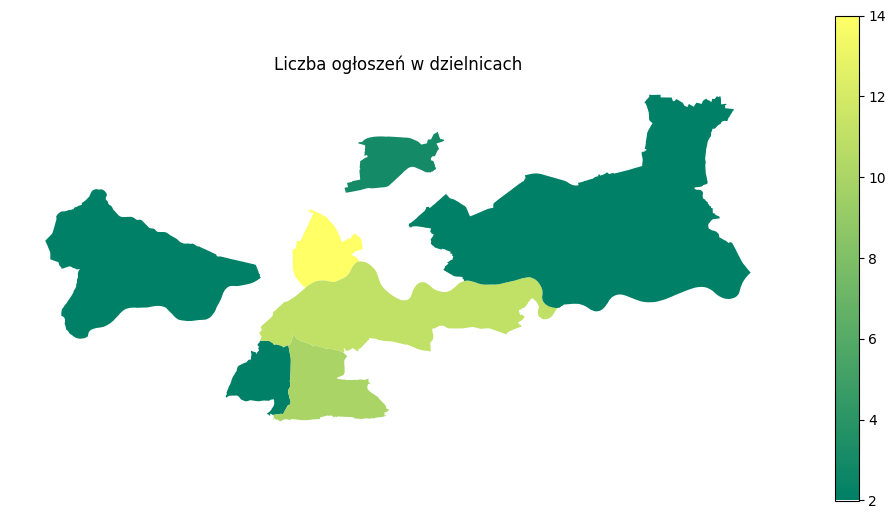

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_qnty.plot(column='qnty', cmap='summer', linewidth=1.5, ax=ax)

vmin, vmax = df_district_qnty['qnty'].min(), df_district_qnty['qnty'].max()
sm = plt.cm.ScalarMappable(cmap='summer', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Liczba ogłoszeń w dzielnicach")
plt.tight_layout()
# plt.show()

In [9]:
# Remove "zł/m²" from the Prices column
import re
df['Cena za metr'] = df['Cena za metr'].str.replace('zł/m²', '')
df['Cena'] = df['Cena'].str.replace('zł', '')
df['Powierzchnia'] = df['Powierzchnia'].str.replace(' m²', '')

df['Cena'] = df['Cena'].str.replace(',', '.')

for i in range (0,df['Cena za metr'].size):
  df['Cena za metr'][i] = re.sub("\s", "", df['Cena za metr'][i])

for i in range (0,df['Cena'].size):
  df['Cena'][i] = re.sub("\s", "", df['Cena'][i])


# Print the modified DataFrame
df.head(n=5)

,Region,Cena,Cena za metr,Ile pokoi,Powierzchnia
0,Podgórze,1113502.60,15580,4,71.47
1,Podgórze,655023.90,16090,1,40.71
2,Podgórze,936137.40,14740,2,63.51
3,Grzegórzki,863008,18100,1,47.68
4,Grzegórzki,815328,17100,1,47.68


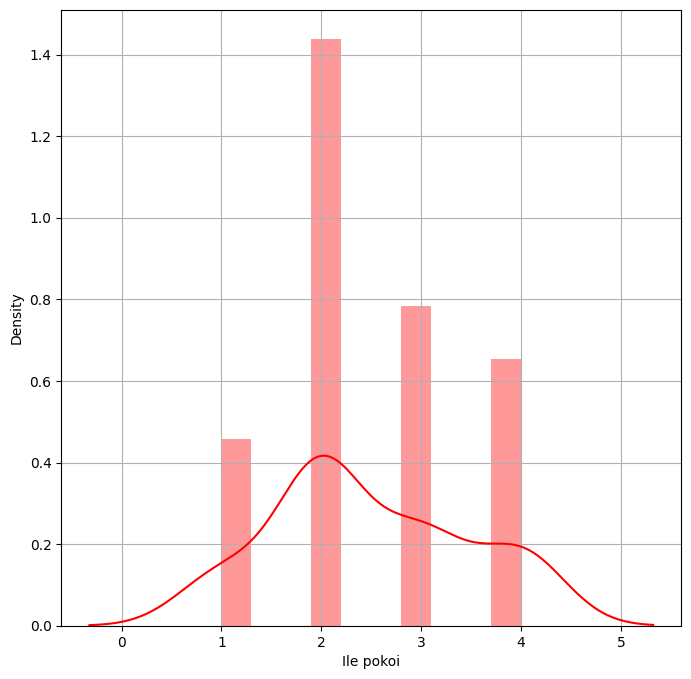

In [8]:
# histogram dla liczby pokojów

plt.figure(figsize=(8,8))
sns.distplot(df["Ile pokoi"], bins=10, kde=True, color='red')
plt.grid()

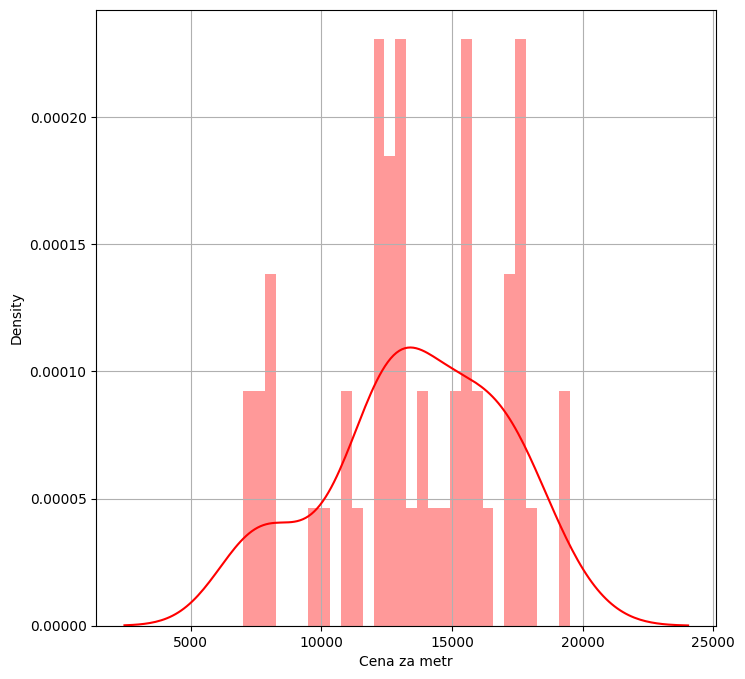

In [ ]:
# histogram dla ceny za m2
# Convert the Prices column to numeric type
df['Cena za metr'] = df['Cena za metr'].astype(float)

plt.figure(figsize=(8,8))
sns.distplot(df["Cena za metr"], bins=30, kde=True, color='red')
plt.grid()

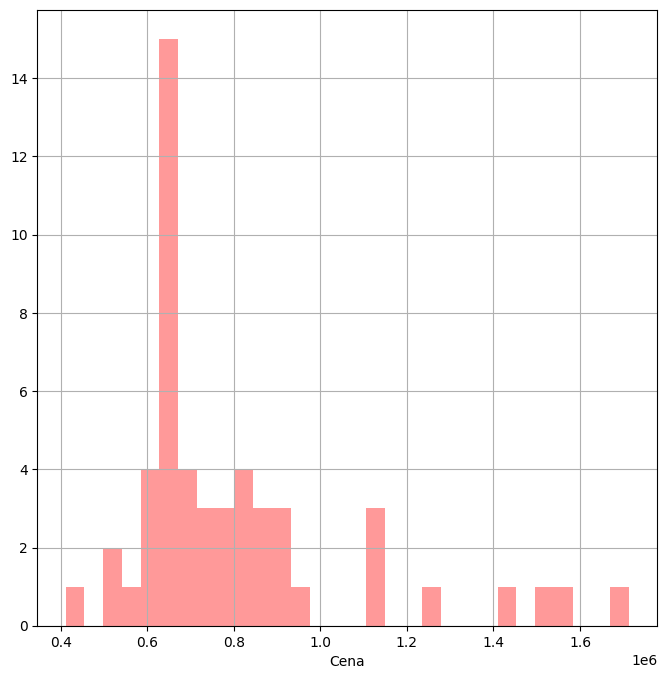

In [ ]:
# Histogram dla ceny nieruchomości

plt.figure(figsize=(8,8))
sns.distplot(df['Cena'], bins=30, kde=False, color='red')
plt.grid()

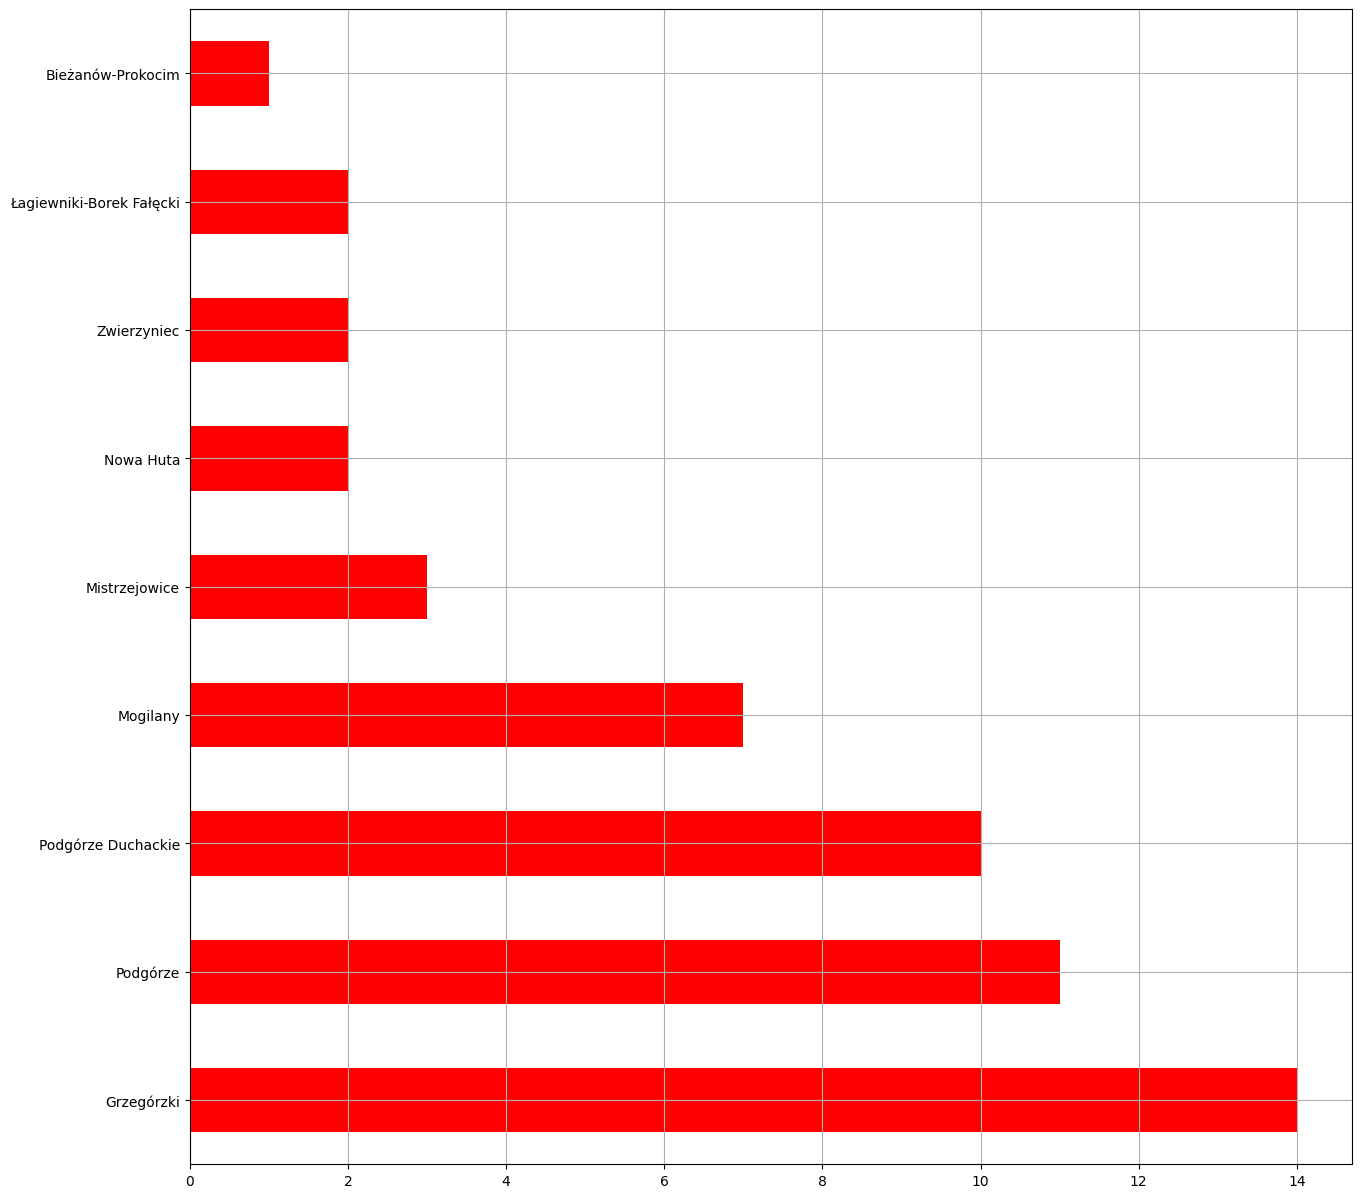

In [ ]:
# liczba ogłoszeń dla danej dzielnicy

df["Region"].value_counts().sort_values(ascending=False).head(20).plot(kind='barh',
                                                            figsize=(15,15), color='red', grid=True)
plt.show()

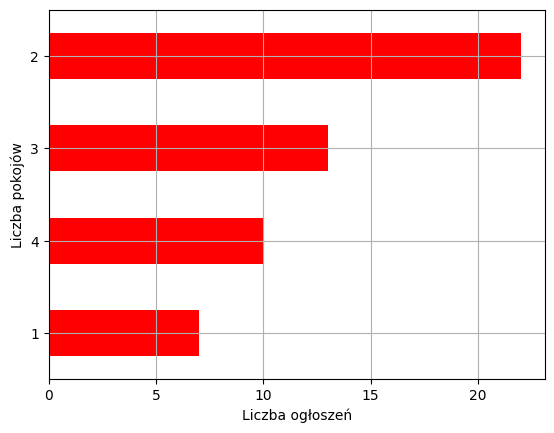

In [ ]:
# liczba ogłoszeń dla danej liczby pokojów

df["Ile pokoi"].value_counts().sort_values().plot(kind='barh', grid=True, color='red')
plt.xlabel('Liczba ogłoszeń')
plt.ylabel('Liczba pokojów')
plt.show()